In [1]:
from htm.bindings.sdr import SDR
from htm.algorithms import SpatialPooler
from htm.bindings.algorithms import TemporalMemory
import numpy as np
import pandas as pd
import pathlib
import datetime
import csv
from datetime import datetime
import os
from htm.encoders.rdse import RDSE, RDSE_Parameters
import time
import traceback
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
inputSources = [
   "monthly_sp500_pca.csv",
   "weekly_dow_jones.csv",
   "weekly_nasdaq.csv",
   "weekly_sp500.csv",
   "monthly_vix_close.csv",
   "monthly_vix_high.csv",
   "monthly_vix_low.csv",
   "monthly_vix_open.csv",
   "daily_natural_gas.csv",
   "daily_oil_prices.csv",
   "value1_vix_close.csv",
   "value1_vix_high.csv",
   "value1_vix_low.csv",
   "value1_vix_open.csv",
   "monthly_gold_prices.csv"
]

In [3]:

config = {
    'enc': {
        "value" :
            {'resolution': 0.88, 'size': 700, 'sparsity': 0.02},
        "time": 
            {'timeOfDay': (30, 1), 'weekend': 21}
    },
    'sp': {
        'inputDimensions': None,
        'columnDimensions': (1638,),
        'potentialPct': 0.85,
        'potentialRadius': None,
        'globalInhibition': True,
        'localAreaDensity': 0.04395604395604396,
        'synPermInactiveDec': 0.006,
        'synPermActiveInc': 0.04,
        'synPermConnected': 0.13999999999999999,
        'boostStrength': 3.0,
        'wrapAround': True,
        'seed': 1,
        'learn': False,
    },
    'tm': {
        'cellsPerColumn': 13,
        'activationThreshold': 17,
        'initialPermanence': 0.21,
        'minThreshold': 10,
        'maxNewSynapseCount': 32,
        'permanenceIncrement': 0.1,
        'permanenceDecrement': 0.1,
        'predictedSegmentDecrement': 0.0,
        'maxSegmentsPerCell': 128,
        'maxSynapsesPerSegment': 64,
        'learn': True
    },
    'anomaly': {'period': 1000},
    'learnRows': 100,
    'reflexSize': 2048,
    'accuracyThreshold': 0.5,
    'controlThreshold': 4
}


In [4]:
class ReflexiveMemory:
  def __init__(self, reflexSize, dimensions_dense, dimensions_sparse_sp):
    self.acKey0 = None
    self.pairs = {}
    self.tableSize  = reflexSize
    self.dimensions_dense = dimensions_dense
    self.dimensions_sparse_sp = dimensions_sparse_sp

  def add(self, denseColumns):
    acKey1 = '-'.join(map(str, denseColumns.sparse))
    if(self.acKey0 != None):

      sequence = self.pairs.get(self.acKey0, {})
      sequence_data = sequence.get(acKey1, {
         "count": 0,
         "time": datetime.now()
      })
      if sequence_data["count"] < 256:
        sequence_data["count"] = sequence_data["count"] + 1
      sequence_data["time"] = datetime.now()

      if self.pairs.get(self.acKey0, None) is None:
        self.pairs[self.acKey0] = { acKey1: sequence_data }
      else:
        self.pairs[self.acKey0][acKey1] = sequence_data
        
      table_entries = 0
      oldKey1 = None
      oldKey2 = None
      oldTime = datetime.now()
      for key1, value1 in self.pairs.items():
        table_entries = table_entries + len(value1.items())
        for key2, value2 in value1.items():
          if value2['time'] < oldTime:
            oldKey1 = key1
            oldKey2 = key2
            oldTime = value2['time']
      if table_entries > self.tableSize:
        del self.pairs[oldKey1][oldKey2]
        if len(self.pairs[oldKey1].items()) == 0:
          del self.pairs[oldKey1]

    self.acKey0 = acKey1

  def predict(self, denseColumns):
    return_count = 0
    return_sdr = None

    acKey = '-'.join(map(str, denseColumns.sparse))
    sequences = self.pairs.get(acKey, {})
    for sequence_key, sequence_data in sequences.items():
      if sequence_data["count"] > return_count:
        return_count = sequence_data["count"]
        return_sdr = sequence_key

    if return_sdr is not None:
      tmp_sdr = SDR( self.dimensions_dense )
      tmp_sdr.sparse = list(map(int, return_sdr.split('-')))
      return_sdr = tmp_sdr
    else:
      return_count = None

    return return_count, return_sdr


In [5]:
class ControlHistory:
  def __init__(self):
    self.anomalyRM = []
    self.anomalyTM = []
    self.anomalyNU = []
    self.historyRM = []
    self.historyTM = []
    self.historyGT = []

  def anomalyScore(self, y, x):
      if np.count_nonzero(y) != 0:
          return 1 - np.count_nonzero((x & y)) / np.count_nonzero(y)
      return 1

  def add(self, denseColumns1, sp, tm, rm):

    if rm.acKey0 is not None:

      denseColumns0 = SDR( rm.dimensions_dense )
      denseColumns0.sparse = list(map(int, rm.acKey0.split('-')))

      tm.activateDendrites(True)
      predictiveCells = tm.getPredictiveCells()

      predictiveColumns = SDR( rm.dimensions_sparse_sp )
      predictiveColumns.sparse = list(set(sorted(list(np.where(predictiveCells.dense == 1)[0]))))

      reflexiveColumns = SDR( rm.dimensions_sparse_sp )
      reflexiveCount, denseReflexiveColumns = rm.predict(denseColumns0)
      if denseReflexiveColumns is not None:
        sp.compute(denseReflexiveColumns, False, reflexiveColumns)

      activeColumns0 = SDR( rm.dimensions_sparse_sp )
      sp.compute(denseColumns0, False, activeColumns0)

      activeColumns1 = SDR( rm.dimensions_sparse_sp )
      sp.compute(denseColumns1, False, activeColumns1)

      self.historyRM.append( reflexiveColumns.dense )
      self.historyTM.append( predictiveColumns.dense )
      self.historyGT.append( activeColumns1.dense )

      self.anomalyNU.append(tm.anomaly)
      self.anomalyRM.append( self.anomalyScore(activeColumns1.dense, reflexiveColumns.dense) )
      self.anomalyTM.append( self.anomalyScore(activeColumns1.dense, predictiveColumns.dense) )


In [6]:
class ControlUnit:
  def __init__(self, controlThreshold):
    self.anomalyCU = []
    self.historyCU = []
    self.countRMCU = 0
    self.controlThreshold = controlThreshold

  def compute(self, ch, rm):

    if rm.acKey0 is not None:

      rmin = -1-self.controlThreshold
      if (len(ch.anomalyRM) > self.controlThreshold) and (sum(ch.anomalyRM[rmin:-1]) > sum(ch.anomalyTM[rmin:-1])):
        self.anomalyCU.append( ch.anomalyTM[-1] )
        self.historyCU.append( ch.historyTM[-1] )
        self.countRMCU = self.countRMCU + 1
      else:
        self.anomalyCU.append( ch.anomalyRM[-1] )
        self.historyCU.append( ch.historyRM[-1] )


In [7]:
input_path = pathlib.Path('../datasets/numenta')
dataset_metrics = []

pbar = tqdm(total=len(inputSources))
for dataset in inputSources:

    tm_infer_tm = 0
    tm_infer_rm = 0

    records = []
    with open(input_path.joinpath(dataset), "r") as fin:
        reader = csv.reader(fin)
        headers = next(reader)
        next(reader)
        next(reader)
        for record in reader:
            records.append(record)
        
    scalarEncoderParams = RDSE_Parameters()
    scalarEncoderParams.size = config["enc"]["value"]["size"]
    scalarEncoderParams.sparsity = config["enc"]["value"]["sparsity"]
    scalarEncoderParams.resolution = config["enc"]["value"]["resolution"]
    scalarEncoder = RDSE( scalarEncoderParams )
    encodingWidth = (scalarEncoder.size)

    config['sp']['inputDimensions'] = (encodingWidth,)
    config['sp']['potentialRadius'] = encodingWidth

    sp = SpatialPooler(
        inputDimensions = config['sp']['inputDimensions'],
        columnDimensions = config['sp']['columnDimensions'],
        potentialPct = config['sp']['potentialPct'],
        potentialRadius = config['sp']['potentialRadius'],
        globalInhibition = config['sp']['globalInhibition'],
        localAreaDensity = config['sp']['localAreaDensity'],
        synPermInactiveDec = config['sp']['synPermInactiveDec'],
        synPermActiveInc = config['sp']['synPermActiveInc'],
        synPermConnected = config['sp']['synPermConnected'],
        boostStrength = config['sp']['boostStrength'],
        wrapAround = config['sp']['wrapAround'],
        seed = config['sp']['seed']
    )

    tm = TemporalMemory(
        columnDimensions = config['sp']['columnDimensions'],
        cellsPerColumn = config['tm']['cellsPerColumn'],
        activationThreshold = config['tm']['activationThreshold'],
        initialPermanence = config['tm']['initialPermanence'],
        connectedPermanence = config['sp']['synPermConnected'],
        minThreshold = config['tm']['minThreshold'],
        maxNewSynapseCount = config['tm']['maxNewSynapseCount'],
        permanenceIncrement = config['tm']['permanenceIncrement'],
        permanenceDecrement = config['tm']['permanenceDecrement'],
        predictedSegmentDecrement = config['tm']['predictedSegmentDecrement'],
        maxSegmentsPerCell = config['tm']['maxSegmentsPerCell'],
        maxSynapsesPerSegment = config['tm']['maxSynapsesPerSegment']
    )

    rm = ReflexiveMemory( config['reflexSize'] , config['sp']['inputDimensions'], config['sp']['columnDimensions'])

    ch = ControlHistory()
    cu01 = ControlUnit( 1 )
    cu02 = ControlUnit( 2 )
    cu04 = ControlUnit( 4 )
    cu08 = ControlUnit( 8 )
    cu16 = ControlUnit( 16 )
    cu32 = ControlUnit( 32 )
    cu64 = ControlUnit( 64 )


    try:
        
        for count, record in enumerate(records):
            
            learn_sp = config['sp']['learn']
            learn_tm = config['tm']['learn']
            if count < config['learnRows']:
                learn_sp = True
                learn_tm = True

            consumption = float(record[1])
            consumptionBits = scalarEncoder.encode(consumption)
            encoding = SDR( consumptionBits )

            ch.add(encoding, sp, tm, rm)
            cu01.compute(ch, rm)
            cu02.compute(ch, rm)
            cu04.compute(ch, rm)
            cu08.compute(ch, rm)
            cu16.compute(ch, rm)
            cu32.compute(ch, rm)
            cu64.compute(ch, rm)


            tmp_tm = time.time()
            rm.add(encoding)
            rm.predict(encoding)
            tm_infer_rm = tm_infer_rm + (time.time() - tmp_tm)

            activeColumns = SDR( sp.getColumnDimensions() )

            tmp_tm = time.time()
            sp.compute(encoding, learn_sp, activeColumns)
            tm.compute(activeColumns, learn=learn_tm)
            tm_infer_tm = tm_infer_tm + (time.time() - tmp_tm)

    except Exception as e:
        print(traceback.format_exc())
        print(e)

    def match(y, x, idx1, ch, accuracyThreshold):
        n_samples = len(y)
        score1 = ch.anomalyScore(y[idx1], x[idx1])
        if score1 > (1 - accuracyThreshold):
            idx_closest = None
            score_closest = None
            for idx2 in range(n_samples):
                score2 = ch.anomalyScore(y[idx2], x[idx1])
                if score_closest is None or score_closest > score2:
                    score_closest = score2
                    idx_closest = idx2
            return idx_closest
        return idx1

    def calculateMetrics(config, cu, ch, tm_infer_rm, tm_infer_tm, suffix):

        metric = {}

        n_samples = len(ch.historyGT)

        Y_labels = list(range(n_samples))
        X_labels = [ match(ch.historyGT, cu.historyCU, idx, ch, config['accuracyThreshold']) for idx in range(n_samples)]

        total_infe_time = 0
        avg_infer_time_rm = tm_infer_rm / len(ch.anomalyRM)
        avg_infer_time_tm = tm_infer_tm / len(ch.anomalyTM)
        total_infe_time = total_infe_time + (avg_infer_time_rm * cu.countRMCU)
        total_infe_time = total_infe_time + (avg_infer_time_tm * (len(cu.anomalyCU) - cu.countRMCU))

        metric['rm-count-'+suffix] = cu.countRMCU
        metric['anomaly-samples-'+suffix] = len(cu.historyCU)
        metric['tm-count-'+suffix] = len(cu.historyCU) - cu.countRMCU

        metric['total-infer-time-'+suffix] = total_infe_time
        metric['infer-time-'+suffix] = total_infe_time / len(cu.anomalyCU)
        metric['accuracy-'+suffix] = accuracy_score(Y_labels, X_labels)

        X_labels = [ match(ch.historyGT, ch.historyTM, idx, ch, config['accuracyThreshold']) for idx in range(n_samples)]
        metric['accuracy-improvement-'+suffix] = metric['accuracy-'+suffix] - accuracy_score(Y_labels, X_labels)
        metric['infer-speedup-'+suffix] = 1 - (total_infe_time / tm_infer_tm)

        return metric

    metric = {}
    metric['dataset'] = dataset
    metric.update( calculateMetrics(config, cu01, ch, tm_infer_rm, tm_infer_tm, 'cu01') )
    metric.update( calculateMetrics(config, cu02, ch, tm_infer_rm, tm_infer_tm, 'cu02') )
    metric.update( calculateMetrics(config, cu04, ch, tm_infer_rm, tm_infer_tm, 'cu04') )
    metric.update( calculateMetrics(config, cu08, ch, tm_infer_rm, tm_infer_tm, 'cu08') )
    metric.update( calculateMetrics(config, cu16, ch, tm_infer_rm, tm_infer_tm, 'cu16') )
    metric.update( calculateMetrics(config, cu32, ch, tm_infer_rm, tm_infer_tm, 'cu32') )
    metric.update( calculateMetrics(config, cu64, ch, tm_infer_rm, tm_infer_tm, 'cu64') )

    dataset_metrics.append(metric)
    pbar.update(1)
    # break

pbar.close()

100%|██████████| 15/15 [07:11<00:00, 28.74s/it]


In [8]:
df = pd.DataFrame(dataset_metrics)
df.to_csv('metrics.csv', index=False)

In [9]:
table_1_features = ['dataset'] + [v for v in df.columns if 'accuracy-cu' in v]
df[table_1_features]

,dataset,accuracy-cu01,accuracy-cu02,accuracy-cu04,accuracy-cu08,accuracy-cu16,accuracy-cu32,accuracy-cu64
0,monthly_sp500_pca.csv,0.354662,0.375990,0.395491,0.400975,0.399756,0.400975,0.397319
1,weekly_dow_jones.csv,0.023088,0.031746,0.035594,0.037037,0.037037,0.036075,0.035594
2,weekly_nasdaq.csv,0.199519,0.215385,0.220192,0.220192,0.220192,0.219712,0.212500
3,weekly_sp500.csv,0.320038,0.345026,0.353196,0.353676,0.352715,0.352715,0.348390
4,monthly_vix_close.csv,0.902963,0.945926,0.964198,0.966914,0.966173,0.966173,0.965926
5,monthly_vix_high.csv,0.858765,0.915309,0.942222,0.945432,0.945679,0.946667,0.946173
6,monthly_vix_low.csv,0.912840,0.956296,0.973086,0.976790,0.976296,0.977778,0.978272
7,monthly_vix_open.csv,0.887901,0.931605,0.952346,0.957284,0.957037,0.956790,0.956543
8,daily_natural_gas.csv,0.969817,0.973784,0.979993,0.984132,0.987927,0.991549,0.993101
9,daily_oil_prices.csv,0.977590,0.985783,0.990241,0.992892,0.993976,0.994096,0.994217


In [10]:
table_2_features = ['dataset'] + [v for v in df.columns if 'total-infer-time' in v]
df[table_2_features]

,dataset,total-infer-time-cu01,total-infer-time-cu02,total-infer-time-cu04,total-infer-time-cu08,total-infer-time-cu16,total-infer-time-cu32,total-infer-time-cu64
0,monthly_sp500_pca.csv,0.238710,0.174075,0.124702,0.103457,0.099866,0.102858,0.109142
1,weekly_dow_jones.csv,0.516268,0.423521,0.345469,0.284521,0.238268,0.215141,0.214660
2,weekly_nasdaq.csv,0.388218,0.291231,0.229376,0.201150,0.188839,0.184335,0.192443
3,weekly_sp500.csv,0.292516,0.211326,0.171814,0.158553,0.158553,0.160988,0.169649
4,monthly_vix_close.csv,0.558614,0.318121,0.175903,0.133742,0.131070,0.131664,0.135227
5,monthly_vix_high.csv,0.559610,0.326937,0.185922,0.145087,0.137155,0.136567,0.141561
6,monthly_vix_low.csv,0.376150,0.239990,0.152528,0.121420,0.116371,0.116371,0.117511
7,monthly_vix_open.csv,0.573622,0.333716,0.191786,0.140508,0.134709,0.131657,0.137151
8,daily_natural_gas.csv,0.337898,0.312933,0.277942,0.237293,0.195205,0.156294,0.124430
9,daily_oil_prices.csv,0.603072,0.468132,0.363802,0.300836,0.273075,0.268663,0.270042


In [11]:
table_3_features = ['dataset'] + [v for v in df.columns if 'infer-time' in v and 'total' not in v]
df[table_3_features]

,dataset,infer-time-cu01,infer-time-cu02,infer-time-cu04,infer-time-cu08,infer-time-cu16,infer-time-cu32,infer-time-cu64
0,monthly_sp500_pca.csv,0.000145,0.000106,0.000076,0.000063,0.000061,0.000063,0.000067
1,weekly_dow_jones.csv,0.000248,0.000204,0.000166,0.000137,0.000115,0.000103,0.000103
2,weekly_nasdaq.csv,0.000187,0.000140,0.000110,0.000097,0.000091,0.000089,0.000093
3,weekly_sp500.csv,0.000141,0.000102,0.000083,0.000076,0.000076,0.000077,0.000082
4,monthly_vix_close.csv,0.000138,0.000079,0.000043,0.000033,0.000032,0.000033,0.000033
5,monthly_vix_high.csv,0.000138,0.000081,0.000046,0.000036,0.000034,0.000034,0.000035
6,monthly_vix_low.csv,0.000093,0.000059,0.000038,0.000030,0.000029,0.000029,0.000029
7,monthly_vix_open.csv,0.000142,0.000082,0.000047,0.000035,0.000033,0.000033,0.000034
8,daily_natural_gas.csv,0.000058,0.000054,0.000048,0.000041,0.000034,0.000027,0.000021
9,daily_oil_prices.csv,0.000073,0.000056,0.000044,0.000036,0.000033,0.000032,0.000033


In [12]:
table_4_features = ['dataset'] + [v for v in df.columns if 'accuracy-improvement' in v]
df[table_4_features]

,dataset,accuracy-improvement-cu01,accuracy-improvement-cu02,accuracy-improvement-cu04,accuracy-improvement-cu08,accuracy-improvement-cu16,accuracy-improvement-cu32,accuracy-improvement-cu64
0,monthly_sp500_pca.csv,-0.045094,-0.023766,-0.004266,0.001219,0.000000,0.001219,-0.002438
1,weekly_dow_jones.csv,-0.013949,-0.005291,-0.001443,0.000000,0.000000,-0.000962,-0.001443
2,weekly_nasdaq.csv,-0.022115,-0.006250,-0.001442,-0.001442,-0.001442,-0.001923,-0.009135
3,weekly_sp500.csv,-0.032677,-0.007689,0.000481,0.000961,0.000000,0.000000,-0.004325
4,monthly_vix_close.csv,-0.061975,-0.019012,-0.000741,0.001975,0.001235,0.001235,0.000988
5,monthly_vix_high.csv,-0.086914,-0.030370,-0.003457,-0.000247,0.000000,0.000988,0.000494
6,monthly_vix_low.csv,-0.064691,-0.021235,-0.004444,-0.000741,-0.001235,0.000247,0.000741
7,monthly_vix_open.csv,-0.068889,-0.025185,-0.004444,0.000494,0.000247,0.000000,-0.000247
8,daily_natural_gas.csv,-0.023456,-0.019489,-0.013280,-0.009141,-0.005347,-0.001725,-0.000172
9,daily_oil_prices.csv,-0.015783,-0.007590,-0.003133,-0.000482,0.000602,0.000723,0.000843


In [13]:
table_5_features = ['dataset'] + [v for v in df.columns if 'infer-speedup' in v]
df[table_5_features]

,dataset,infer-speedup-cu01,infer-speedup-cu02,infer-speedup-cu04,infer-speedup-cu08,infer-speedup-cu16,infer-speedup-cu32,infer-speedup-cu64
0,monthly_sp500_pca.csv,0.589162,0.700403,0.785378,0.821943,0.828123,0.822973,0.812158
1,weekly_dow_jones.csv,0.262554,0.395035,0.506526,0.593585,0.659654,0.692688,0.693376
2,weekly_nasdaq.csv,0.513380,0.634950,0.712484,0.747864,0.763295,0.768941,0.758779
3,weekly_sp500.csv,0.591181,0.704651,0.759874,0.778407,0.778407,0.775003,0.762900
4,monthly_vix_close.csv,0.575144,0.758052,0.866216,0.898282,0.900314,0.899862,0.897153
5,monthly_vix_high.csv,0.572696,0.750360,0.858035,0.889215,0.895272,0.895721,0.891907
6,monthly_vix_low.csv,0.508042,0.686122,0.800512,0.841198,0.847801,0.847801,0.846310
7,monthly_vix_open.csv,0.575706,0.753159,0.858141,0.896070,0.900359,0.902617,0.898553
8,daily_natural_gas.csv,0.104210,0.170394,0.263156,0.370919,0.482497,0.585654,0.670127
9,daily_oil_prices.csv,0.409672,0.541761,0.643886,0.705522,0.732695,0.737014,0.735664


In [14]:
table_6_features = ['dataset'] + sorted(list(set(df.columns) - (set(table_1_features) | set(table_2_features) | set(table_3_features) | set(table_4_features) | set(table_5_features))))
df[table_6_features]

,dataset,anomaly-samples-cu01,anomaly-samples-cu02,anomaly-samples-cu04,anomaly-samples-cu08,anomaly-samples-cu16,anomaly-samples-cu32,anomaly-samples-cu64,rm-count-cu01,rm-count-cu02,...,rm-count-cu16,rm-count-cu32,rm-count-cu64,tm-count-cu01,tm-count-cu02,tm-count-cu04,tm-count-cu08,tm-count-cu16,tm-count-cu32,tm-count-cu64
0,monthly_sp500_pca.csv,1641,1641,1641,1641,1641,1641,1641,1144,1360,...,1608,1598,1577,497,281,116,45,33,43,64
1,weekly_dow_jones.csv,2079,2079,2079,2079,2079,2079,2079,763,1148,...,1917,2013,2015,1316,931,607,354,162,66,64
2,weekly_nasdaq.csv,2080,2080,2080,2080,2080,2080,2080,1364,1687,...,2028,2043,2016,716,393,187,93,52,37,64
3,weekly_sp500.csv,2081,2081,2081,2081,2081,2081,2081,1563,1863,...,2058,2049,2017,518,218,72,23,23,32,64
4,monthly_vix_close.csv,4050,4050,4050,4050,4050,4050,4050,2547,3357,...,3987,3985,3973,1503,693,214,72,63,65,77
5,monthly_vix_high.csv,4050,4050,4050,4050,4050,4050,4050,2553,3345,...,3991,3993,3976,1497,705,225,86,59,57,74
6,monthly_vix_low.csv,4050,4050,4050,4050,4050,4050,4050,2385,3221,...,3980,3980,3973,1665,829,292,101,70,70,77
7,monthly_vix_open.csv,4050,4050,4050,4050,4050,4050,4050,2550,3336,...,3988,3998,3980,1500,714,249,81,62,52,70
8,daily_natural_gas.csv,5798,5798,5798,5798,5798,5798,5798,792,1295,...,3667,4451,5093,5006,4503,3798,2979,2131,1347,705
9,daily_oil_prices.csv,8300,8300,8300,8300,8300,8300,8300,4553,6021,...,8143,8191,8176,3747,2279,1144,459,157,109,124


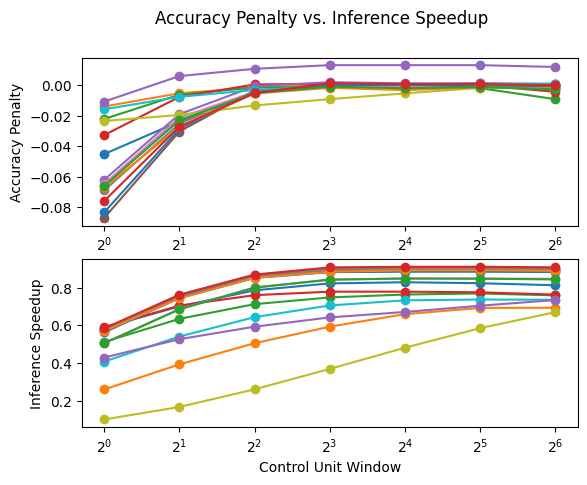

In [18]:
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Accuracy Penalty vs. Inference Speedup')

# ax1.set_xlabel("Control Unit Window")
ax1.set_ylabel("Accuracy Penalty")
ax1.set_xscale('log', base=2) 

columns = [v for v in df.columns if 'accuracy-improvement-cu' in v]
for row in df[columns].values:
    ax1.plot([int(v.lstrip('accuracy-improvement-cu')) for v in columns], row, label='Line 1', marker='o')

ax2.set_xlabel("Control Unit Window")
ax2.set_ylabel("Inference Speedup")
ax2.set_xscale('log', base=2) 

columns = [v for v in df.columns if 'infer-speedup-cu' in v]
for row in df[columns].values:
    ax2.plot([int(v.lstrip('infer-speedup-cu')) for v in columns], row, marker='o')

fig.show()

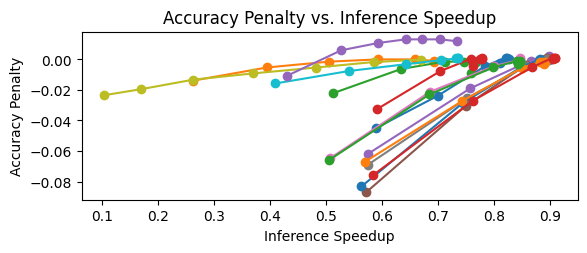

In [ ]:
plt.subplot(2,1,2)
plt.title("Accuracy Penalty vs. Inference Speedup")
plt.xlabel("Inference Speedup")
plt.ylabel("Accuracy Penalty")
plt.xscale('linear') 

xcolumns = [v for v in df.columns if 'infer-speedup-cu' in v]
ycolumns = [v for v in df.columns if 'accuracy-improvement-cu' in v]
for xrow, yrow  in zip(df[xcolumns].values, df[ycolumns].values):
    plt.plot(xrow, yrow, marker='o')
# plt.legend(labels=df['dataset'].values)
plt.show()

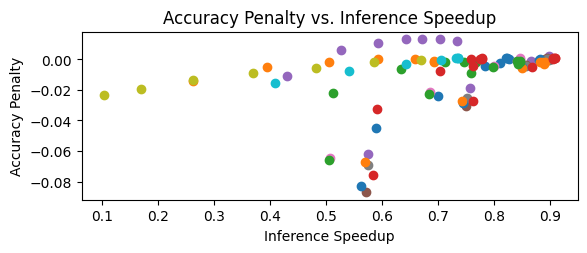

In [20]:
plt.subplot(2,1,2)
plt.title("Accuracy Penalty vs. Inference Speedup")
plt.xlabel("Inference Speedup")
plt.ylabel("Accuracy Penalty")
plt.xscale('linear') 

xcolumns = [v for v in df.columns if 'infer-speedup-cu' in v]
ycolumns = [v for v in df.columns if 'accuracy-improvement-cu' in v]
for xrow, yrow  in zip(df[xcolumns].values, df[ycolumns].values):
    plt.scatter(xrow, yrow, marker='o')
# plt.legend(labels=df['dataset'].values)
plt.show()